In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from vae.datasets import SABRDataset, SABRExFeatsDataset
from vae.cvae_with_mem import CVAEMem
from vae.utils import *
from data_preproc.sabr_gen import SABRSurface

In [2]:
set_seeds(0)
torch.set_default_dtype(torch.float64)

In [3]:
data = np.load("data/sabr_surface_with_ret.npz")
vol_surf_data = data["surface"]
ret_data = data["ret"]
price_data = data["price"]
train_ret = DataLoader(SABRExFeatsDataset(vol_surf_data[:5000], ret_data[:5000], 5), shuffle=True, batch_size=64)
valid_ret = DataLoader(SABRExFeatsDataset(vol_surf_data[5000:6000], ret_data[5000:6000], 5), shuffle=True, batch_size=16)
test_ret = DataLoader(SABRExFeatsDataset(vol_surf_data[6000:7000], ret_data[6000:7000], 5), shuffle=True, batch_size=16)

train_price = DataLoader(SABRExFeatsDataset(vol_surf_data[:5000], price_data[:5000], 5), shuffle=True, batch_size=64)
valid_price = DataLoader(SABRExFeatsDataset(vol_surf_data[5000:6000], price_data[5000:6000], 5), shuffle=True, batch_size=16)
test_price = DataLoader(SABRExFeatsDataset(vol_surf_data[6000:7000], price_data[6000:7000], 5), shuffle=True, batch_size=16)

train_simple = DataLoader(SABRDataset(vol_surf_data[:5000], 5), shuffle=True, batch_size=64)
valid_simple = DataLoader(SABRDataset(vol_surf_data[5000:6000], 5), shuffle=True, batch_size=16)
test_simple = DataLoader(SABRDataset(vol_surf_data[6000:7000], 5), shuffle=True, batch_size=16)

In [3]:
def generate_surface_path(surf_data, ex_data, model_data, path_idx=8000):
    model_config = model_data["model_config"]
    model = CVAEMem(model_config)
    model.load_weights(dict_to_load=model_data)
    seq_len = model_config["seq_len"]
    use_ex_feats = model_config["ex_feats_dim"] > 0
    all_simulation = {
        "surface": [surf_data[path_idx][i] for i in range(seq_len-1)],
        "ex_feats": [ex_data[path_idx][i] for i in range(seq_len-1)] if use_ex_feats else None,
    }
    steps_to_sim = len(vol_surf_data[path_idx]) + 1 - seq_len
    for i in range(steps_to_sim):
        ctx_data = {
            "surface": torch.from_numpy(np.array(all_simulation["surface"][i:(i+seq_len-1)])), 
            "ex_feats": torch.from_numpy(np.array(all_simulation["ex_feats"][i:(i+seq_len-1)])).unsqueeze(-1) if use_ex_feats else None
        }
        if use_ex_feats:
            surf, ex_feat = model.get_surface_given_conditions(ctx_data) 
        else:
            ctx_data.pop("ex_feats")
            surf = model.get_surface_given_conditions(ctx_data) 
        surf = surf.detach().cpu().numpy().reshape((5,5))
        all_simulation["surface"].append(surf)
        if use_ex_feats:
            ex_feat = ex_feat.detach().cpu().numpy().reshape((1,))[0]
            all_simulation["ex_feats"].append(ex_feat)

    all_simulation["surface"] = np.array(all_simulation["surface"])
    if use_ex_feats:
        all_simulation["ex_feats"] = np.array(all_simulation["ex_feats"])
    
    return all_simulation

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as Func

class SABRBackwardModel(nn.Module):
    def __init__(self, r=0, q=0,
                beta=1, rho=-0.7, volvol=0.3, 
                moneyness_grid=[0.7, 0.85, 1, 1.15, 1.3], ttm_grid=[0.08333, 0.25, 0.5, 1, 2]) -> None:
        super().__init__()
        self.r = r
        self.q = q
        self.beta = beta
        self.rho = rho
        self.volvol = volvol
        self.moneyness_grid = moneyness_grid
        self.ttm_grid = ttm_grid
    
    def forward(self, vol, price):
        """Convert SABR instantaneous vol to option implied vol

        Args:
            vol (np.ndarray): SABR instantaneous vol in shape (num_path, num_period)
            price (np.ndarray): underlying stock price in shape (num_path, num_period)
        Returns:
            np.ndarray: implied vol in shape (num_paths, num_period, ttm_grid, moneyness_grid)
        """
        SABRIVs = torch.zeros((vol.shape[0], vol.shape[1], len(self.ttm_grid), len(self.moneyness_grid)))
        for t in range(len(self.ttm_grid)):
            for i in range(len(self.moneyness_grid)):
                K = price * self.moneyness_grid[i] # (num_path, num_period)
                F = price * torch.exp(torch.tensor((self.r - self.q) * t)) # (num_path, num_period)
                x = (F * K) ** ((1 - self.beta) / 2) # (num_path, num_period)
                y = (1 - self.beta) * torch.log(F / K) # (num_path, num_period)
                A = vol / (x * (1 + y * y / 24 + y * y * y * y / 1920)) # (num_path, num_period)
                B = 1 + t * (
                        ((1 - self.beta) ** 2) * (vol * vol) / (24 * x * x)
                        + self.rho * self.beta * self.volvol * vol / (4 * x)
                        + self.volvol * self.volvol * (2 - 3 * self.rho * self.rho) / 24
                ) # (num_path, num_period)
                Phi = (self.volvol * x / vol) * torch.log(F / K) # (num_path, num_period)
                Chi = torch.log((torch.sqrt(1 - 2 * self.rho * Phi + Phi * Phi) + Phi - self.rho) / (1 - self.rho)) # (num_path, num_period)
                SABRIV = torch.where(F == K, vol * B / (F ** (1 - self.beta)), A * B * Phi / (Chi+1e-8)) # (num_path, num_period)
                SABRIVs[:, :, t, i] = SABRIV

        return SABRIVs
    
    def search(self, prices, vols, target, lr=0.1, iterations=50):
        prices = prices.clone().detach().requires_grad_(True)
        vols = vols.clone().detach().requires_grad_(True)
        optim = torch.optim.SGD([prices, vols], lr=lr)

        for i in range(iterations):
            optim.zero_grad()
            predicted = self.forward(vols, prices)
            loss = Func.mse_loss(predicted, target)
            print(f"iteration {i}: loss={loss}")
            loss.backward()
            optim.step()
        return prices, vols

## beta=0.5

In [54]:
gen = SABRSurface(beta=0.5)
a_price, implied_vol, sabr_vol = gen.get_sim_path_sabr()

Generating asset price paths (SABR)
Generating implied vol


In [55]:
surface_data = torch.from_numpy(implied_vol[0].reshape((1,31,5,5)))
checker = SABRBackwardModel(beta=0.5)
prices = torch.randn((1, 31)) + 10
vols = torch.rand((1, 31))
final_prices, final_vols = checker.search(prices, vols, surface_data, lr=1, iterations=5000)

iteration 0: loss=0.017280254243496173
iteration 1: loss=0.017052256193241574
iteration 2: loss=0.016827283918290532
iteration 3: loss=0.0166052972074621
iteration 4: loss=0.01638625638381039
iteration 5: loss=0.016170122297483696
iteration 6: loss=0.01595685631868221
iteration 7: loss=0.015746420330712847
iteration 8: loss=0.015538776723139575
iteration 9: loss=0.015333888385027984
iteration 10: loss=0.015131718698282528
iteration 11: loss=0.014932231531075124
iteration 12: loss=0.014735391231363677
iteration 13: loss=0.014541162620499277
iteration 14: loss=0.014349510986920637
iteration 15: loss=0.014160402079934572
iteration 16: loss=0.013973802103581234
iteration 17: loss=0.013789677710582732
iteration 18: loss=0.013607995996374116
iteration 19: loss=0.01342872449321537
iteration 20: loss=0.013251831164383252
iteration 21: loss=0.013077284398441856
iteration 22: loss=0.012905053003590756
iteration 23: loss=0.012735106202089536
iteration 24: loss=0.012567413624757712
iteration 25: l

In [24]:
print(f"true price: \n{a_price[0]}")
print(f"initial search price: \n{prices}")
print(f"fitted price: \n{final_prices}")
print()
print(f"true vol: \n{sabr_vol[0]}")
print(f"initial search vol: \n{vols}")
print(f"fitted vol: \n{final_vols}")

true price: 
[10.         10.02803429  9.95750297 10.04281688 10.02454812  9.98233488
 10.03434373 10.08385728 10.04800185 10.04872626  9.9237217   9.99019354
 10.04659383 10.10023978  9.98927588  9.97059038  9.97055947  9.99168334
 10.00658166 10.0754659   9.99728504  9.9868787   9.95304732  9.96291505
  9.99060591 10.05562941 10.03304881 10.06600718  9.97993513  9.97078025
 10.0233986 ]
initial search price: 
tensor([[ 9.1087,  9.5535,  9.2988, 10.3263,  9.1261, 10.3941, 10.8915, 11.1732,
          9.2434, 10.3687,  9.8273, 10.9751, 10.4165,  9.5013,  9.5245,  9.3170,
         10.4313,  9.6344,  9.4688,  9.8659, 11.3643, 10.2328, 11.1064, 10.2370,
          8.4805, 11.0216, 11.1149,  9.4440, 10.5332,  9.8121, 10.3994]])
fitted price: 
tensor([[ 9.1283,  9.5537,  9.3070, 10.3242,  9.1242, 10.4036, 10.8898, 11.1757,
          9.2625, 10.3687,  9.8255, 10.9742, 10.4282,  9.5063,  9.5304,  9.3156,
         10.4437,  9.6437,  9.4785,  9.8645, 11.3696, 10.2328, 11.1050, 10.2497,
          

In [25]:
ivs = gen._sabr_implied_vol(final_vols.detach().numpy(), final_prices.detach().numpy())
ivs_r = gen._sabr_implied_vol(final_vols.detach().numpy(), np.random.rand(1, 31) + 10)
print(f"true iv surface: {implied_vol[0][0]}")
print(f"fitted iv surface: {ivs[0, 0]}")
print(f"random price {ivs_r[0, 0]}")

true iv surface: [[0.14216816 0.11638012 0.09486833 0.07847523 0.06992765]
 [0.14207959 0.11632142 0.09482952 0.07844934 0.0699093 ]
 [0.14199101 0.11626272 0.09479072 0.07842346 0.06989094]
 [0.14190244 0.11620402 0.09475191 0.07839757 0.06987259]
 [0.14181387 0.11614532 0.09471311 0.07837168 0.06985423]]
fitted iv surface: [[0.14216816 0.11638012 0.09486833 0.07847523 0.06992765]
 [0.14207959 0.11632142 0.09482952 0.07844934 0.0699093 ]
 [0.14199101 0.11626272 0.09479072 0.07842346 0.06989094]
 [0.14190244 0.11620402 0.09475191 0.07839757 0.06987259]
 [0.14181387 0.11614532 0.09471311 0.07837168 0.06985423]]
random price [[0.13303782 0.10774897 0.08656377 0.07070033 0.06352783]
 [0.13298414 0.10771726 0.08654587 0.07069085 0.06352325]
 [0.13293047 0.10768554 0.08652798 0.07068138 0.06351867]
 [0.1328768  0.10765382 0.08651008 0.07067191 0.06351409]
 [0.13282313 0.1076221  0.08649218 0.07066244 0.06350951]]


## beta = 1

In [26]:
gen = SABRSurface(beta=1)
a_price, implied_vol, sabr_vol = gen.get_sim_path_sabr()

Generating asset price paths (SABR)
Generating implied vol


In [27]:
surface_data = torch.from_numpy(implied_vol[0].reshape((1,31,5,5)))
checker = SABRBackwardModel(beta=1)
prices = torch.randn((1, 31)) + 10
vols = torch.rand((1, 31))
final_prices, final_vols = checker.search(prices, vols, surface_data, lr=1, iterations=1000)

iteration 0: loss=0.09551012769836012
iteration 1: loss=0.08714768708689731
iteration 2: loss=0.07942795498626408
iteration 3: loss=0.07231287231913165
iteration 4: loss=0.06576516609935748
iteration 5: loss=0.059748561686099745
iteration 6: loss=0.05422795768636077
iteration 7: loss=0.04916955836086334
iteration 8: loss=0.04454096852145826
iteration 9: loss=0.0403112581590621
iteration 10: loss=0.036451002979893926
iteration 11: loss=0.03293230543220169
iteration 12: loss=0.029728799558509777
iteration 13: loss=0.026815642198259097
iteration 14: loss=0.02416949257549316
iteration 15: loss=0.021768482011941682
iteration 16: loss=0.019592175319679977
iteration 17: loss=0.017621525295617443
iteration 18: loss=0.01583882163199472
iteration 19: loss=0.014227635456992975
iteration 20: loss=0.01277276062016049
iteration 21: loss=0.011460152736102586
iteration 22: loss=0.010276866896777525
iteration 23: loss=0.00921099485902951
iteration 24: loss=0.008251602411390195
iteration 25: loss=0.0073

In [28]:
print(f"true price: \n{a_price[0]}")
print(f"initial search price: \n{prices}")
print(f"fitted price: \n{final_prices}")
print()
print(f"true vol: \n{sabr_vol[0]}")
print(f"initial search vol: \n{vols}")
print(f"fitted vol: \n{final_vols}")

true price: 
[10.         10.0876894   9.86353329 10.1314488  10.07200587  9.93717157
 10.10048109 10.25804241 10.1415762  10.14280501  9.74716443  9.95318128
 10.1307516  10.30209739  9.94565605  9.88593279  9.88485859  9.95020201
  9.99625167 10.21460849  9.96426737  9.9306352   9.82382144  9.853678
  9.93952406 10.14459812 10.07174849 10.17609104  9.90181953  9.87232966
 10.03692948]
initial search price: 
tensor([[10.6709,  9.5217, 12.1976, 10.1365, 10.8942,  8.0336, 11.4865,  9.8017,
          9.2679,  8.8900,  9.8678, 11.4505, 10.1168, 10.0299, 10.8536,  9.4774,
          9.9748, 11.7608, 10.7085,  9.3315,  9.1742, 10.3012,  9.1096, 10.1355,
          9.1729,  9.0617,  8.9392,  8.4484,  9.6853, 10.2539,  8.9802]])
fitted price: 
tensor([[10.6709,  9.5217, 12.1976, 10.1365, 10.8942,  8.0336, 11.4865,  9.8017,
          9.2679,  8.8900,  9.8678, 11.4505, 10.1168, 10.0299, 10.8536,  9.4774,
          9.9748, 11.7608, 10.7085,  9.3315,  9.1742, 10.3012,  9.1096, 10.1355,
          9.

In [29]:
ivs = gen._sabr_implied_vol(final_vols.detach().numpy(), final_prices.detach().numpy())
ivs_r = gen._sabr_implied_vol(final_vols.detach().numpy(), np.random.rand(1, 31) + 10)
print(f"true iv surface: {implied_vol[0][0]}")
print(f"fitted iv surface: {ivs[0, 0]}")
print(f"random price {ivs_r[0, 0]}")

true iv surface: [[0.33849101 0.31734513 0.3        0.28563797 0.27375237]
 [0.33383253 0.31297766 0.29587125 0.28170688 0.26998485]
 [0.32917405 0.3086102  0.2917425  0.27777578 0.26621733]
 [0.32451556 0.30424274 0.28761375 0.27384469 0.26244981]
 [0.31985708 0.29987528 0.283485   0.2699136  0.2586823 ]]
fitted iv surface: [[0.33849101 0.31734513 0.3        0.28563797 0.27375237]
 [0.33383253 0.31297766 0.29587125 0.28170688 0.26998485]
 [0.32917405 0.3086102  0.2917425  0.27777578 0.26621733]
 [0.32451556 0.30424274 0.28761375 0.27384469 0.26244981]
 [0.31985708 0.29987528 0.283485   0.2699136  0.2586823 ]]
random price [[0.33849101 0.31734513 0.3        0.28563797 0.27375237]
 [0.33383253 0.31297766 0.29587125 0.28170688 0.26998485]
 [0.32917405 0.3086102  0.2917425  0.27777578 0.26621733]
 [0.32451556 0.30424274 0.28761375 0.27384469 0.26244981]
 [0.31985708 0.29987528 0.283485   0.2699136  0.2586823 ]]


## beta = 0

In [34]:
gen = SABRSurface(beta=0)
a_price, implied_vol, sabr_vol = gen.get_sim_path_sabr()

Generating asset price paths (SABR)
Generating implied vol


In [35]:
surface_data = torch.from_numpy(implied_vol[0].reshape((1,31,5,5)))
checker = SABRBackwardModel(beta=0)
prices = torch.randn((1, 31)) + 10
vols = torch.rand((1, 31))
final_prices, final_vols = checker.search(prices, vols, surface_data, lr=1, iterations=20000)

iteration 0: loss=0.0013316574108259444
iteration 1: loss=0.0013293089233922949
iteration 2: loss=0.001326982562211869
iteration 3: loss=0.0013246757346218594
iteration 4: loss=0.001322386379050676
iteration 5: loss=0.0013201128263402853
iteration 6: loss=0.001317853704005636
iteration 7: loss=0.00131560786830671
iteration 8: loss=0.0013133743549074508
iteration 9: loss=0.0013111523422952597
iteration 10: loss=0.0013089411241694786
iteration 11: loss=0.001306740088265687
iteration 12: loss=0.001304548699883739
iteration 13: loss=0.001302366488910513
iteration 14: loss=0.0013001930394777427
iteration 15: loss=0.0012980279816334473
iteration 16: loss=0.0012958709845708564
iteration 17: loss=0.001293721751075452
iteration 18: loss=0.0012915800129344086
iteration 19: loss=0.0012894455271135713
iteration 20: loss=0.001287318072551821
iteration 21: loss=0.0012851974474560796
iteration 22: loss=0.001283083467005265
iteration 23: loss=0.0012809759613906504
iteration 24: loss=0.0012788747741347

In [38]:
print(f"true price: \n{a_price[0]}")
print(f"initial search price: \n{prices}")
print(f"fitted price: \n{final_prices}")
print()
print(f"true vol: \n{sabr_vol[0]}")
print(f"initial search vol: \n{vols}")
print(f"fitted vol: \n{final_vols}")

true price: 
[10.         10.00889538  9.98660661 10.01360243 10.00787012  9.99455501
 10.01102433 10.02666458 10.01539324 10.01565559  9.97608634  9.99717562
 10.01502044 10.03194867  9.99693374  9.99105127  9.99107283  9.99778762
 10.00252769 10.02428192  9.99961349  9.99634893  9.98565972  9.98881557
  9.99760757 10.01816019 10.01105848 10.02147772  9.99429317  9.99142074
 10.00808135]
initial search price: 
tensor([[ 8.6536,  9.8009,  9.2217,  9.4495, 10.3249, 10.5221,  9.3456,  8.1402,
          8.5381, 11.1726, 10.5176,  8.9360,  9.2861, 11.0388, 10.7893,  9.1570,
          7.2374,  8.6393, 11.0969,  9.0778,  8.1935, 11.8679, 10.1623, 10.4479,
         10.6322,  9.8756, 10.7109, 10.0472,  9.8086,  8.7552, 10.4973]])
fitted price: 
tensor([[ 8.6796,  9.7996,  9.2246,  9.4725, 10.3480, 10.5259,  9.3443,  8.1375,
          8.5371, 11.1786, 10.5145,  8.9705,  9.2840, 11.0699, 10.8048,  9.1708,
          7.2772,  8.6364, 11.0993,  9.0789,  8.1977, 11.8799, 10.1664, 10.4538,
         1

In [39]:
ivs = gen._sabr_implied_vol(final_vols.detach().numpy(), final_prices.detach().numpy())
ivs_r = gen._sabr_implied_vol(final_vols.detach().numpy(), np.random.rand(1, 31) + 10)
print(f"true iv surface: {implied_vol[0][0]}")
print(f"fitted iv surface: {ivs[0, 0]}")
print(f"random price {ivs_r[0, 0]}")

true iv surface: [[0.07212063 0.04991899 0.03       0.02289259 0.02854241]
 [0.07226783 0.05002041 0.03006075 0.02293884 0.02859996]
 [0.07241503 0.05012182 0.0301215  0.02298508 0.02865751]
 [0.07256224 0.05022324 0.03018225 0.02303133 0.02871507]
 [0.07270944 0.05032466 0.030243   0.02307757 0.02877262]]
fitted iv surface: [[0.07212064 0.049919   0.03000001 0.0228926  0.02854242]
 [0.07226784 0.05002042 0.03006076 0.02293884 0.02859997]
 [0.07241505 0.05012184 0.03012151 0.02298509 0.02865752]
 [0.07256225 0.05022325 0.03018226 0.02303134 0.02871507]
 [0.07270945 0.05032467 0.03024301 0.02307758 0.02877262]]
random price [[0.06483865 0.04375904 0.02446203 0.01982785 0.02616667]
 [0.06496983 0.04384729 0.02451125 0.01986769 0.02621918]
 [0.065101   0.04393555 0.02456048 0.01990753 0.02627169]
 [0.06523218 0.0440238  0.02460971 0.01994737 0.0263242 ]
 [0.06536336 0.04411206 0.02465894 0.0199872  0.0263767 ]]


In [45]:
p = final_prices.detach().numpy().reshape((31,))
v = final_vols.detach().numpy().reshape((31,))
print(np.corrcoef(np.log(a_price[0][1:]) - np.log(a_price[0][:-1]), np.log(sabr_vol[0][1:]) - np.log(sabr_vol[0][:-1])))
print(np.corrcoef(np.log(a_price[1][1:]) - np.log(a_price[1][:-1]), np.log(sabr_vol[1][1:]) - np.log(sabr_vol[1][:-1])))
print(np.corrcoef(np.log(p[1:]) - np.log(p[:-1]), np.log(v[1:]) - np.log(v[:-1])))

[[ 1.         -0.80202024]
 [-0.80202024  1.        ]]
[[ 1.         -0.52521439]
 [-0.52521439  1.        ]]
[[1.         0.99030781]
 [0.99030781 1.        ]]


In [49]:
log_p = (torch.log(final_prices[0][1:]) - torch.log(final_prices[0][:-1])).unsqueeze(0)
log_v = (torch.log(final_vols[0][1:]) - torch.log(final_vols[0][:-1])).unsqueeze(0)
print(log_p.shape)
print(log_v.shape)
print(torch.corrcoef(torch.cat([log_p, log_v])))

torch.Size([1, 30])
torch.Size([1, 30])
tensor([[1.0000, 0.9903],
        [0.9903, 1.0000]], grad_fn=<ClampBackward1>)


# Ret as ex feats

In [6]:
model_data = torch.load("test/ret/conv2d_mem_sabr_ret3.pt")
sim = generate_surface_path(vol_surf_data, ret_data, model_data, 8000)
surface_data = torch.tensor(sim["surface"]).unsqueeze(0)
print(surface_data.shape)

torch.Size([1, 31, 5, 5])


In [7]:
checker = SABRBackwardModel()
prices = torch.randn((1, 31)) + 10
vols = torch.rand((1, 31)) + 1

In [8]:
print(f"Search space: initial prices {prices}")
print(f"Search space: initial sigma {vols}")

Search space: initial prices tensor([[ 9.1817,  9.7554, 10.3111, 10.0613, 10.0780,  8.7546,  9.3464,  7.7848,
          9.9007,  9.2380,  8.9188, 10.1190,  9.6912, 10.9281, 10.4795, 12.2099,
         11.5465,  9.8374,  8.3457, 10.0516, 10.6288, 10.0245,  9.9643, 11.1628,
          9.1629,  9.6229, 10.3367,  9.9914,  9.9558, 10.8428,  9.1153]])
Search space: initial sigma tensor([[1.1718, 1.9854, 1.6143, 1.7110, 1.6553, 1.9825, 1.3039, 1.0194, 1.8994,
         1.5240, 1.4579, 1.4965, 1.8724, 1.9416, 1.8487, 1.2265, 1.6051, 1.7820,
         1.1469, 1.1168, 1.3718, 1.1720, 1.3001, 1.3213, 1.0268, 1.9195, 1.2694,
         1.4526, 1.4434, 1.9263, 1.6672]])


In [9]:
final_prices, final_vols = checker.search(prices, vols, surface_data, lr=1, iterations=100)

iteration 0: loss=1.043349646187211
iteration 1: loss=0.9793764486814472
iteration 2: loss=0.9180529485044632
iteration 3: loss=0.8593745817227528
iteration 4: loss=0.8033285522909259
iteration 5: loss=0.7498939884718596
iteration 6: loss=0.699042180896084
iteration 7: loss=0.6507368969267668
iteration 8: loss=0.6049347649013312
iteration 9: loss=0.5615857208660615
iteration 10: loss=0.5206335096276408
iteration 11: loss=0.48201623133242294
iteration 12: loss=0.44566692436241284
iteration 13: loss=0.4115141751127222
iteration 14: loss=0.37948274518935704
iteration 15: loss=0.34949420673334725
iteration 16: loss=0.32146757692659444
iteration 17: loss=0.2953199432504727
iteration 18: loss=0.270967071729683
iteration 19: loss=0.24832399117711432
iteration 20: loss=0.22730554733385122
iteration 21: loss=0.20782692174382572
iteration 22: loss=0.189804111186426
iteration 23: loss=0.17315436448478602
iteration 24: loss=0.15779657448637796
iteration 25: loss=0.14365162395226755
iteration 26: l

In [10]:
print(f"price after gradient descent search: {final_prices}")
print(f"volatility after gradient descent search: {vols}")

price after gradient descent search: tensor([[ 9.1817,  9.7554, 10.3111, 10.0613, 10.0780,  8.7546,  9.3464,  7.7848,
          9.9007,  9.2380,  8.9188, 10.1190,  9.6912, 10.9281, 10.4795, 12.2099,
         11.5465,  9.8374,  8.3457, 10.0516, 10.6288, 10.0245,  9.9643, 11.1628,
          9.1629,  9.6229, 10.3367,  9.9914,  9.9558, 10.8428,  9.1153]],
       requires_grad=True)
volatility after gradient descent search: tensor([[0.3034, 0.3124, 0.3071, 0.3075, 0.3063, 0.3098, 0.3048, 0.3030, 0.3087,
         0.3053, 0.3058, 0.3050, 0.3076, 0.3094, 0.3083, 0.3035, 0.3068, 0.3076,
         0.3028, 0.3026, 0.3045, 0.3033, 0.3044, 0.3030, 0.3025, 0.3093, 0.3040,
         0.3049, 0.3056, 0.3094, 0.3064]], requires_grad=True)


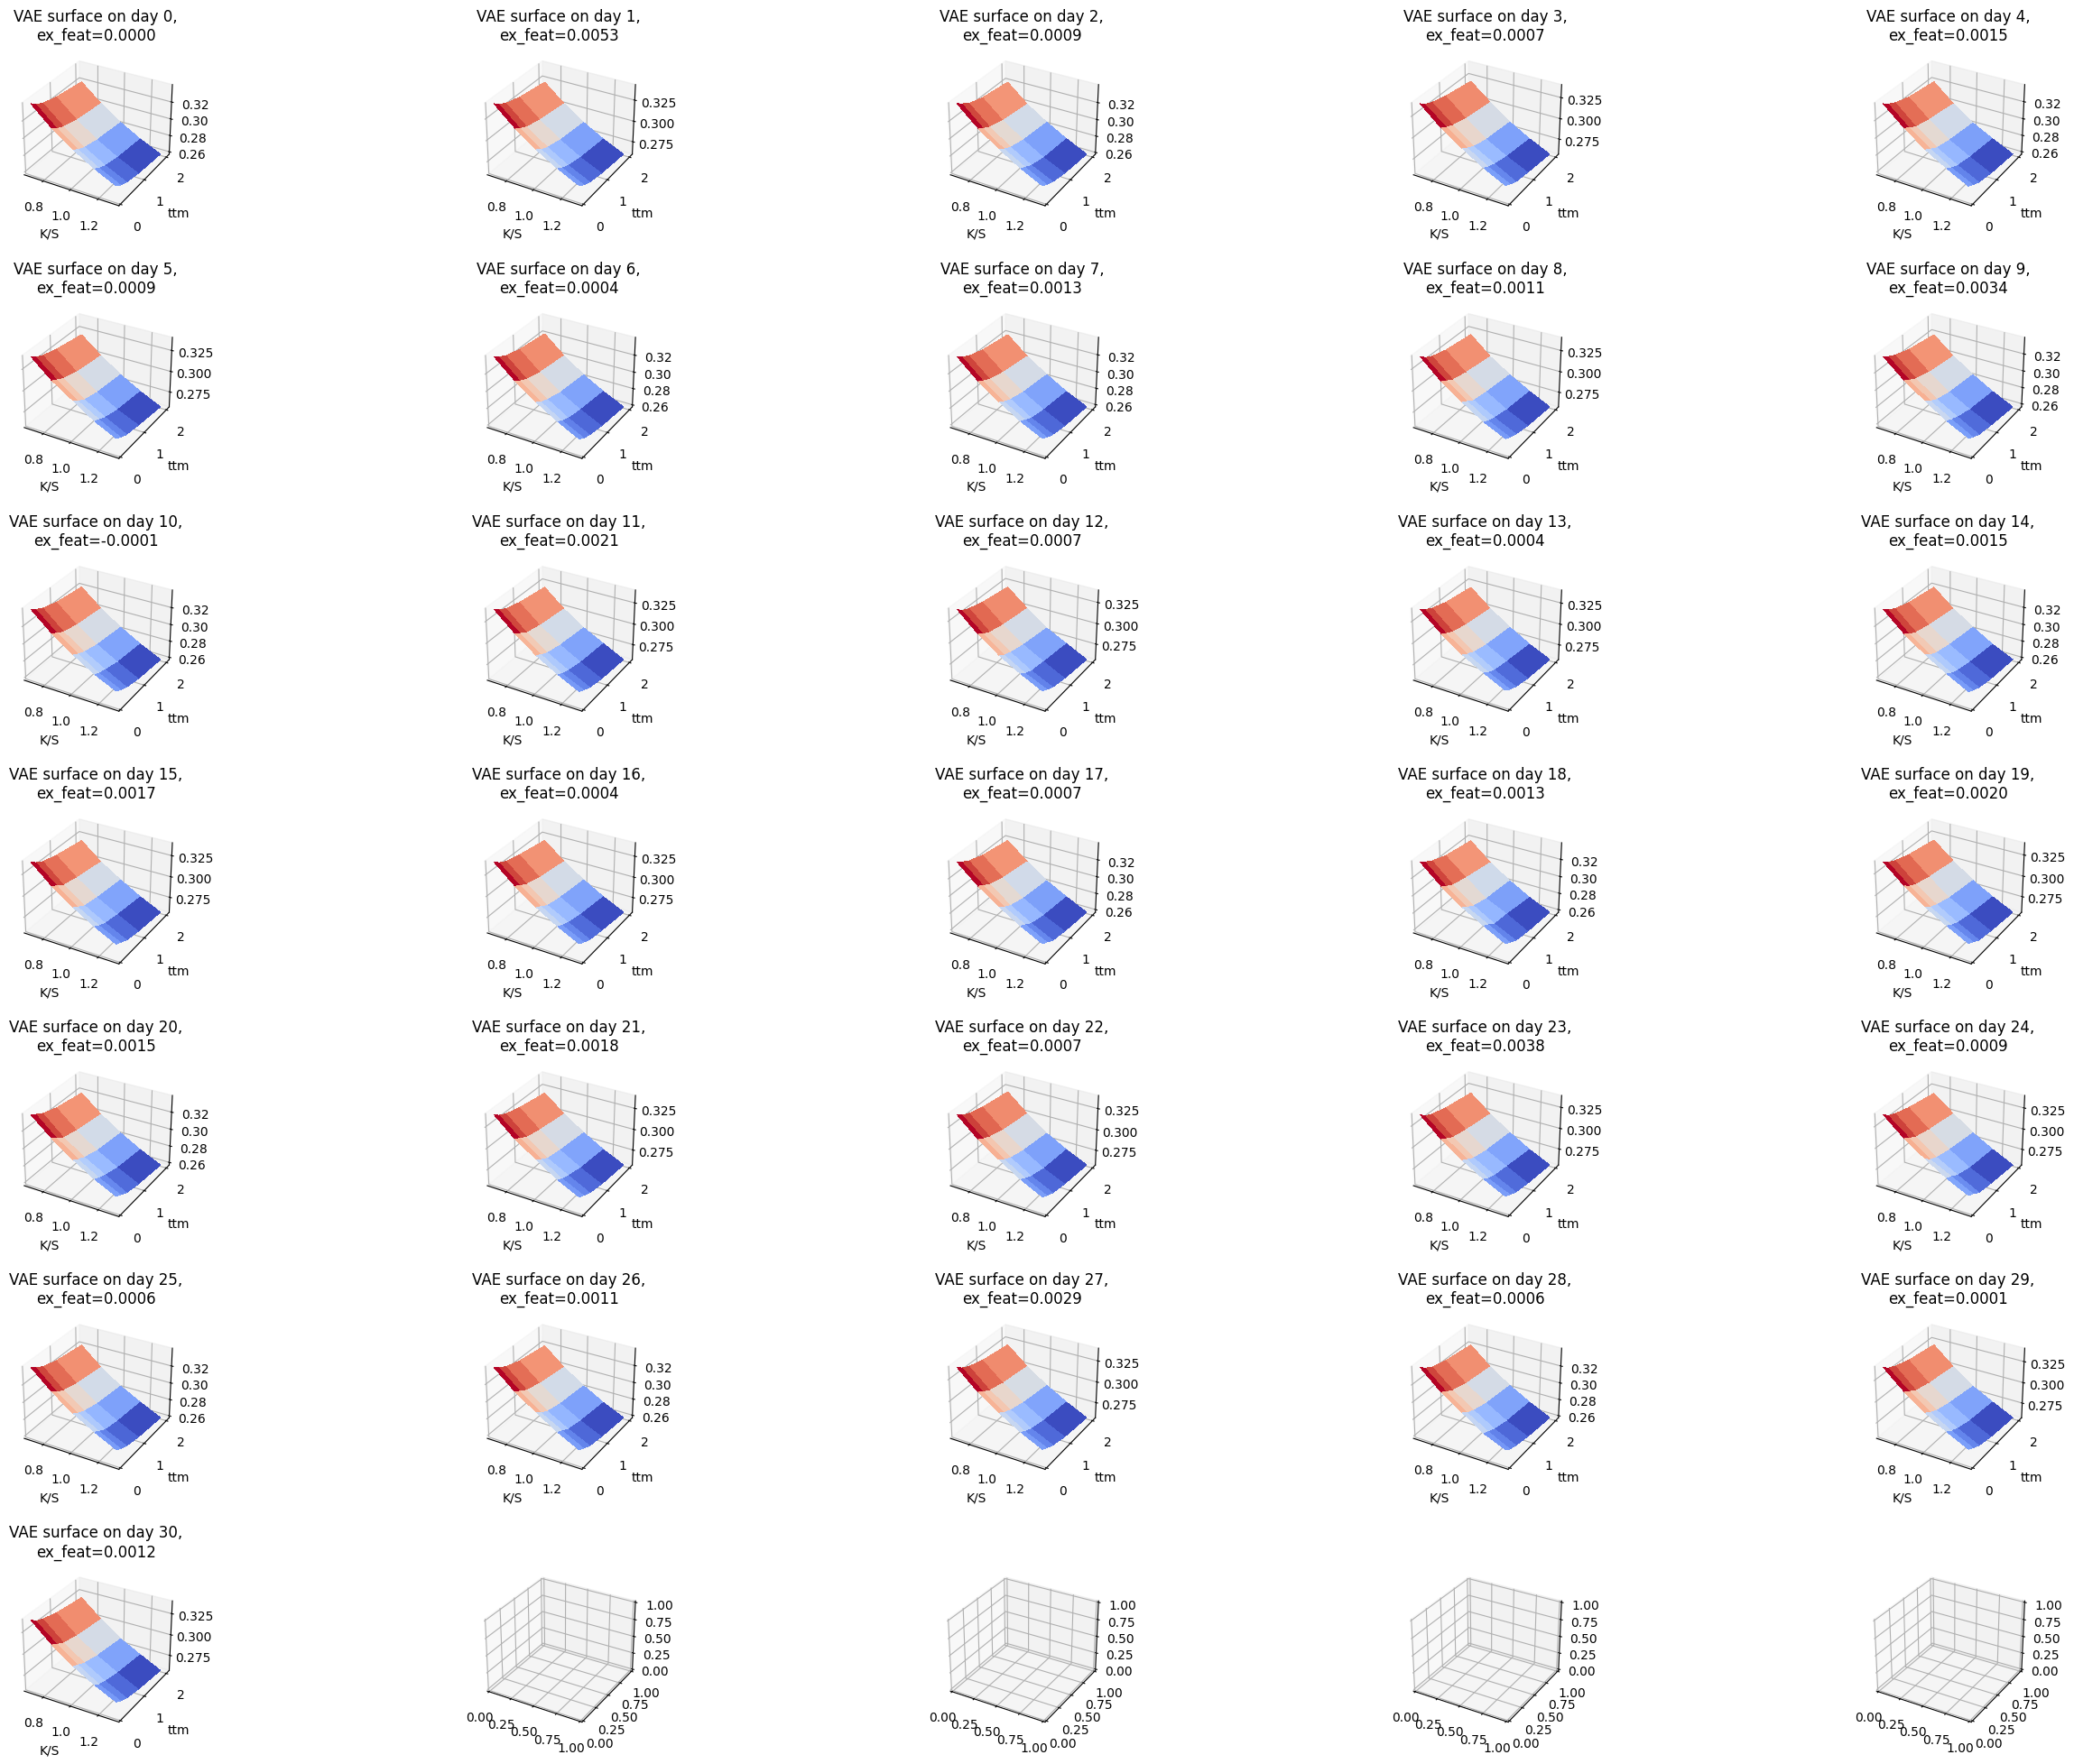

In [11]:
plot_surface_time_series(sim)

In [12]:
print(np.corrcoef(final_prices.detach().numpy(), vols.detach().numpy()))

[[1.         0.10628265]
 [0.10628265 1.        ]]


# simple model (no ex features)

In [13]:
model_data = torch.load("test/simple/conv2d_mem_sabr_no_ex_feats3.pt")

In [14]:
model_data = torch.load("test/simple/conv2d_mem_sabr_no_ex_feats3.pt")
sim = generate_surface_path(vol_surf_data, ret_data, model_data, 8000)
surface_data = torch.tensor(sim["surface"]).unsqueeze(0)

In [15]:
checker2 = SABRBackwardModel()
prices2 = torch.randn((1, 31)) + 10
vols2 = torch.rand((1, 31)) + 1

In [16]:
print(f"Search space: initial prices {prices2}")
print(f"Search space: initial sigma {vols2}")

Search space: initial prices tensor([[11.8628, 10.4652, 10.5584,  9.7311, 10.2753, 10.7443, 10.3105,  9.9335,
         11.3669,  9.8105,  9.0150,  9.5387, 10.4385,  9.9305, 10.1777,  9.3213,
         10.0921, 10.5506, 11.3915,  8.4841, 11.7735, 11.4973, 10.6773,  9.6385,
          9.0169, 11.0159, 10.1902,  9.5133,  9.1002, 11.0043,  9.2072]])
Search space: initial sigma tensor([[1.1211, 1.2461, 1.8959, 1.3365, 1.1696, 1.5097, 1.1760, 1.7911, 1.8245,
         1.7586, 1.0814, 1.1588, 1.4945, 1.2929, 1.4198, 1.7273, 1.7725, 1.7483,
         1.9800, 1.3571, 1.4016, 1.6622, 1.1427, 1.8019, 1.0038, 1.6048, 1.9481,
         1.7458, 1.8315, 1.8426, 1.4975]])


In [17]:
final_prices2, final_vols2 = checker2.search(prices2, vols2, surface_data, lr=1, iterations=300)

iteration 0: loss=1.1440672916044912
iteration 1: loss=1.0739265217078187
iteration 2: loss=1.0066006598226733
iteration 3: loss=0.9420994430986156
iteration 4: loss=0.8804229888049818
iteration 5: loss=0.8215618308652253
iteration 6: loss=0.7654970627020644
iteration 7: loss=0.7122005826414384
iteration 8: loss=0.6616354363533149
iteration 9: loss=0.613756249152046
iteration 10: loss=0.5685097394872439
iteration 11: loss=0.5258353036721116
iteration 12: loss=0.4856656608575656
iteration 13: loss=0.4479275464961605
iteration 14: loss=0.41254244206883883
iteration 15: loss=0.3794273286779489
iteration 16: loss=0.3484954522386082
iteration 17: loss=0.31965708841336815
iteration 18: loss=0.29282029610814164
iteration 19: loss=0.26789164924788694
iteration 20: loss=0.24477693763923553
iteration 21: loss=0.22338182896011832
iteration 22: loss=0.20361248524711575
iteration 23: loss=0.18537612863320177
iteration 24: loss=0.1685815524771234
iteration 25: loss=0.15313957537986397
iteration 26: 

In [18]:
print(f"price after gradient descent search: {final_prices2}")
print(f"volatility after gradient descent search: {vols2}")

price after gradient descent search: tensor([[11.8628, 10.4652, 10.5584,  9.7311, 10.2753, 10.7443, 10.3105,  9.9335,
         11.3669,  9.8105,  9.0150,  9.5387, 10.4385,  9.9305, 10.1777,  9.3213,
         10.0921, 10.5506, 11.3915,  8.4841, 11.7735, 11.4973, 10.6773,  9.6385,
          9.0169, 11.0159, 10.1902,  9.5133,  9.1002, 11.0043,  9.2072]],
       requires_grad=True)
volatility after gradient descent search: tensor([[0.3000, 0.3029, 0.2979, 0.2890, 0.2860, 0.2875, 0.2850, 0.2796, 0.2802,
         0.2807, 0.2800, 0.2743, 0.2666, 0.2633, 0.2639, 0.2595, 0.2555, 0.2461,
         0.2543, 0.2454, 0.2353, 0.2318, 0.2199, 0.2284, 0.2151, 0.2174, 0.2167,
         0.1911, 0.1942, 0.1884, 0.1775]], requires_grad=True)


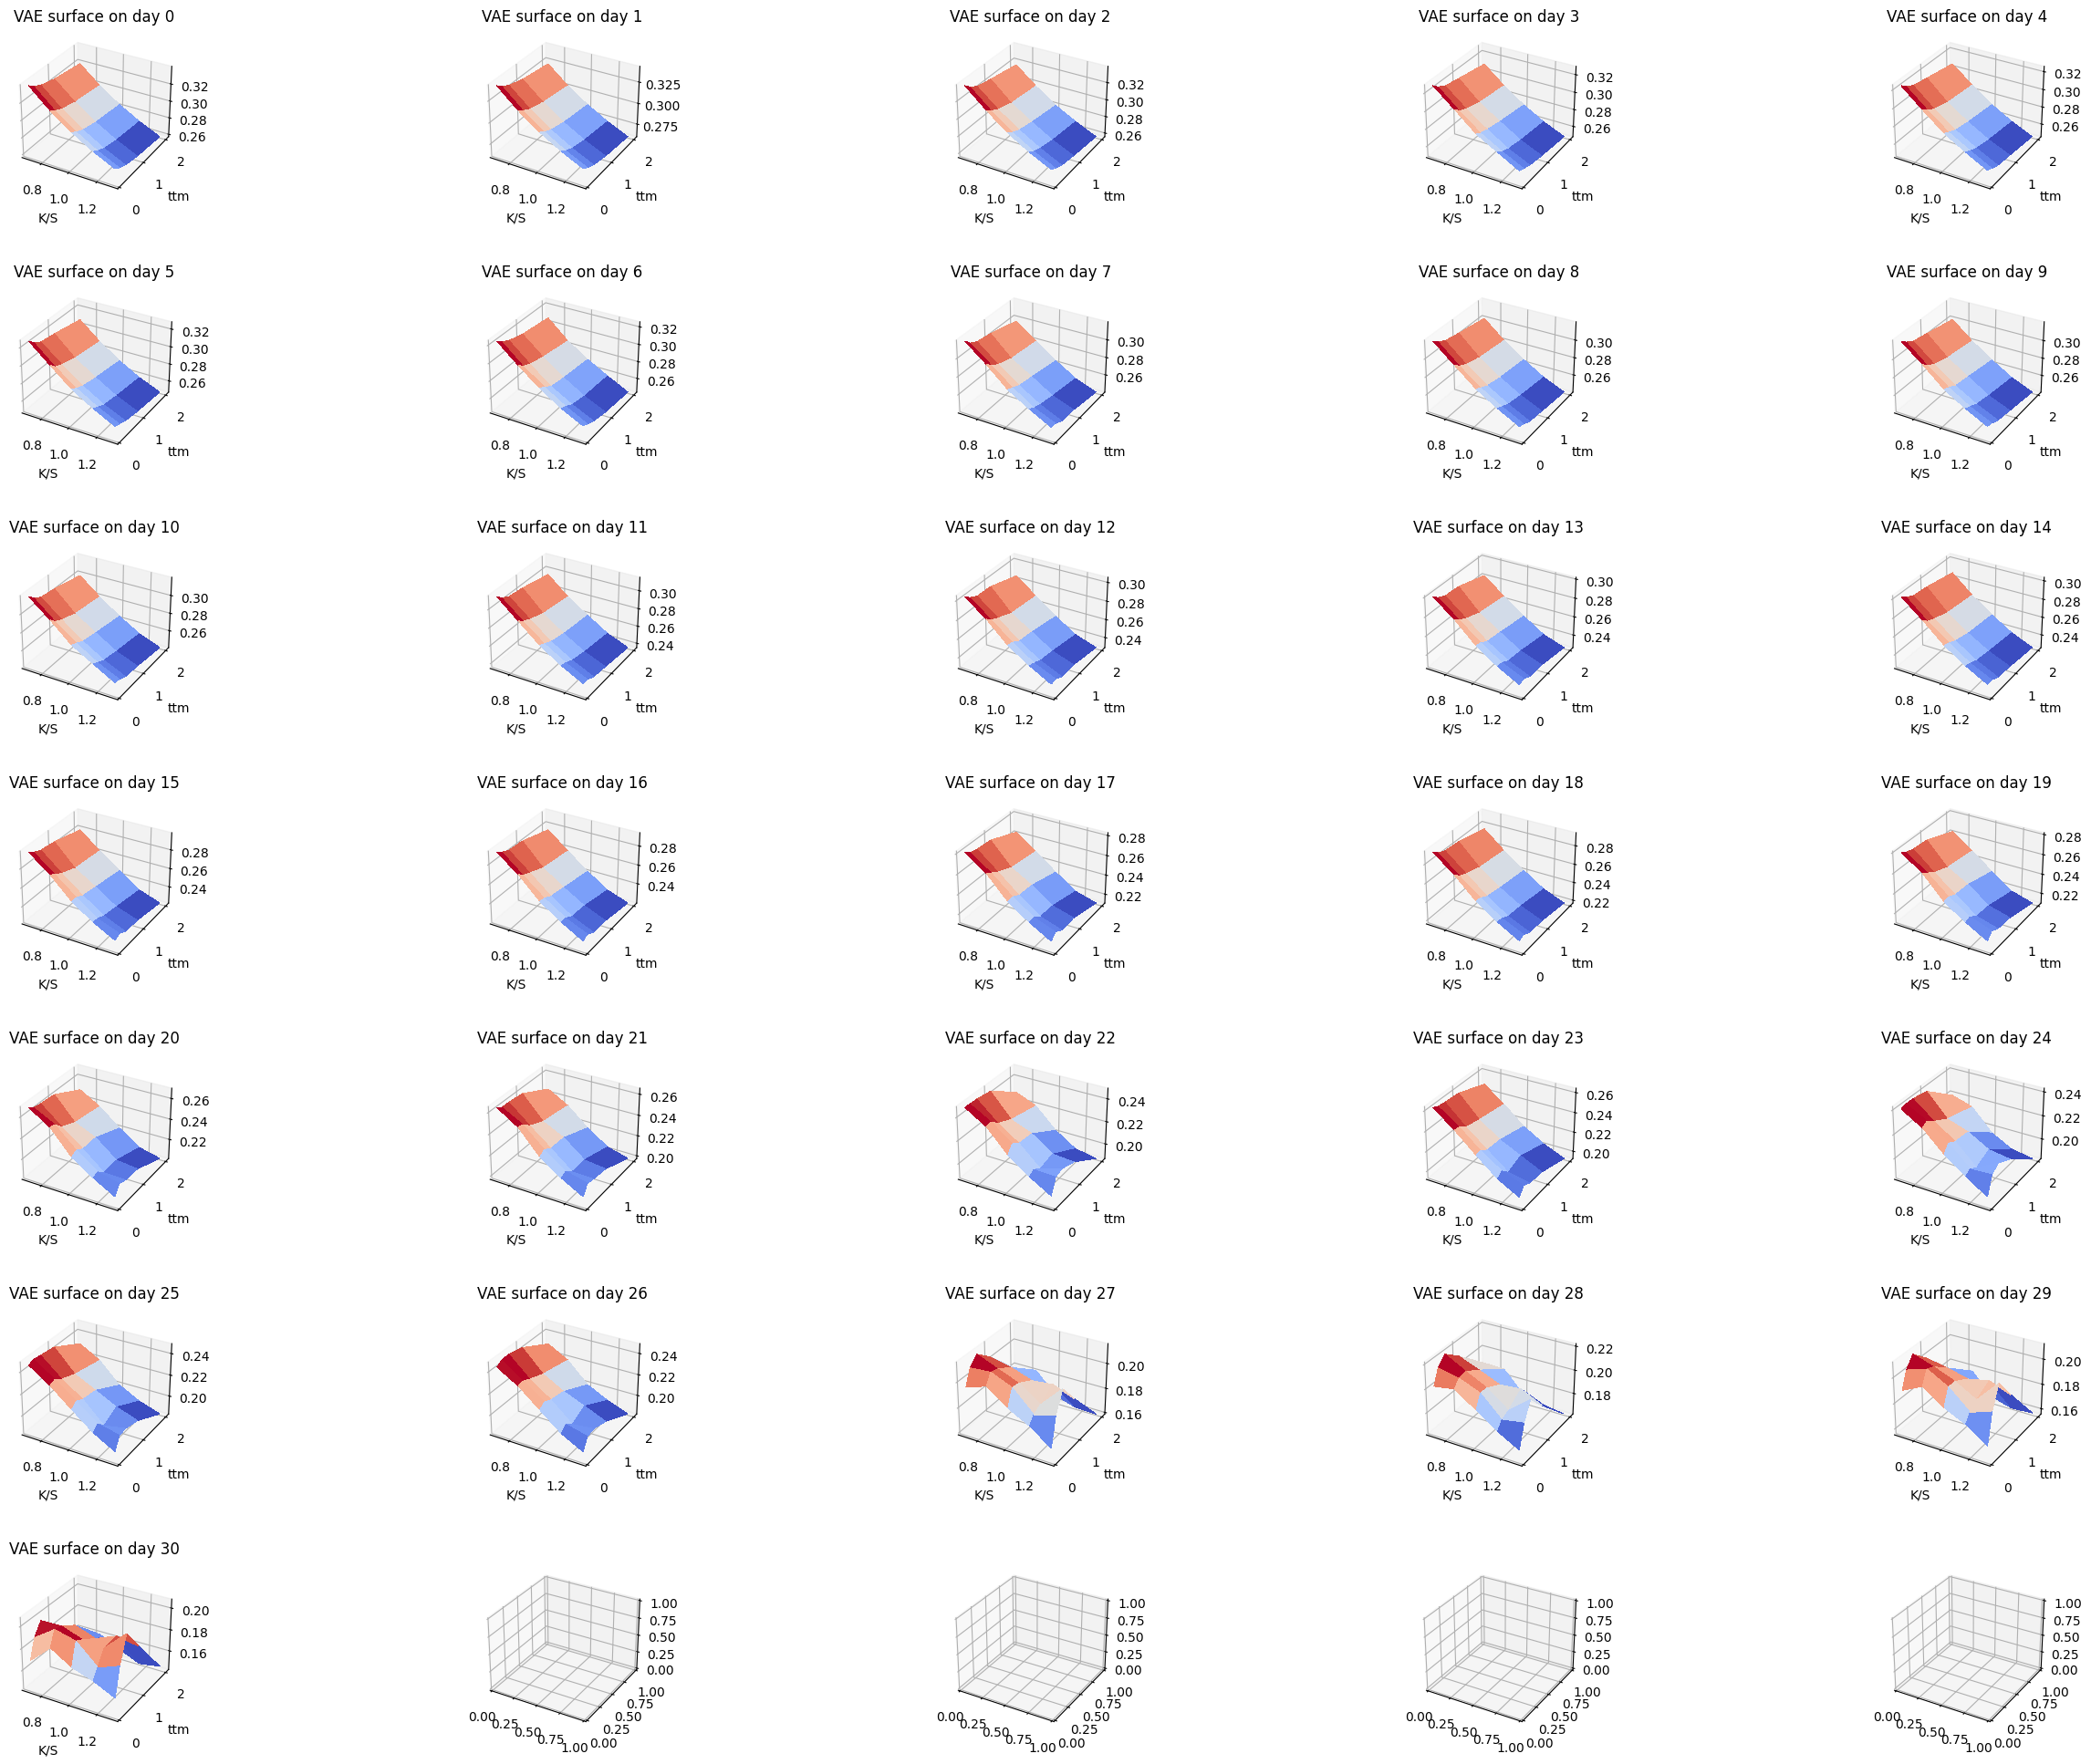

In [19]:
plot_surface_time_series(sim)

In [20]:
sim = generate_surface_path(vol_surf_data, ret_data, model_data, 6000)
surface_data = torch.tensor(sim["surface"]).unsqueeze(0)

In [21]:
checker3 = SABRBackwardModel()
prices3 = torch.randn((1, 31)) + 10
vols3 = torch.rand((1, 31)) + 1

In [22]:
print(f"Search space: initial prices {prices3}")
print(f"Search space: initial sigma {vols3}")

Search space: initial prices tensor([[ 9.4800,  9.4153, 10.0873, 10.0583,  8.5371,  9.2521,  8.8102, 10.8972,
         10.1084,  9.1540,  8.8201, 11.4206,  8.5063,  8.0588, 10.1313, 11.6951,
          9.7234, 11.3856, 10.2249, 10.4046, 10.5627,  9.7447,  9.2137, 10.4840,
         10.3163, 11.6096, 10.4368,  7.8134, 10.6728,  9.2853,  8.3836]])
Search space: initial sigma tensor([[1.2509, 1.1363, 1.3101, 1.7900, 1.5373, 1.9061, 1.4455, 1.4891, 1.7141,
         1.9080, 1.5762, 1.9027, 1.8041, 1.1381, 1.4646, 1.1747, 1.8391, 1.4328,
         1.3210, 1.3361, 1.0492, 1.4512, 1.9592, 1.1258, 1.4356, 1.3131, 1.4053,
         1.2544, 1.3060, 1.6059, 1.2164]])


In [23]:
final_prices3, final_vols3 = checker2.search(prices3, vols3, surface_data, lr=1, iterations=300)

iteration 0: loss=1.1051072639673911
iteration 1: loss=1.0348331690687962
iteration 2: loss=0.9675644536563082
iteration 3: loss=0.9033014635163483
iteration 4: loss=0.8420334438971314
iteration 5: loss=0.7837387936223172
iteration 6: loss=0.7283854407846292
iteration 7: loss=0.675931329932035
iteration 8: loss=0.6263250088926592
iteration 9: loss=0.5795063019698169
iteration 10: loss=0.5354070552004968
iteration 11: loss=0.4939519387201503
iteration 12: loss=0.45505929101114484
iteration 13: loss=0.41864198991628515
iteration 14: loss=0.38460833574598685
iteration 15: loss=0.35286293256226675
iteration 16: loss=0.32330755474171957
iteration 17: loss=0.29584198715510185
iteration 18: loss=0.27036482870209205
iteration 19: loss=0.24677425045458193
iteration 20: loss=0.22496870123984106
iteration 21: loss=0.20484755508826494
iteration 22: loss=0.18631169653554855
iteration 23: loss=0.16926404126768213
iteration 24: loss=0.153609990996857
iteration 25: loss=0.1392578227314934
iteration 26

In [24]:
print(f"price after gradient descent search: {final_prices3}")
print(f"volatility after gradient descent search: {vols3}")

price after gradient descent search: tensor([[ 9.4800,  9.4153, 10.0873, 10.0583,  8.5371,  9.2521,  8.8102, 10.8972,
         10.1084,  9.1540,  8.8201, 11.4206,  8.5063,  8.0588, 10.1313, 11.6951,
          9.7234, 11.3856, 10.2249, 10.4046, 10.5627,  9.7447,  9.2137, 10.4840,
         10.3163, 11.6096, 10.4368,  7.8134, 10.6728,  9.2853,  8.3836]],
       requires_grad=True)
volatility after gradient descent search: tensor([[0.3000, 0.2981, 0.2822, 0.2869, 0.2773, 0.2723, 0.2641, 0.2553, 0.2546,
         0.2552, 0.2360, 0.2416, 0.2357, 0.2365, 0.2285, 0.2177, 0.1852, 0.1934,
         0.1851, 0.2017, 0.1804, 0.1877, 0.1785, 0.1747, 0.1832, 0.1653, 0.1848,
         0.1805, 0.2072, 0.1932, 0.1771]], requires_grad=True)


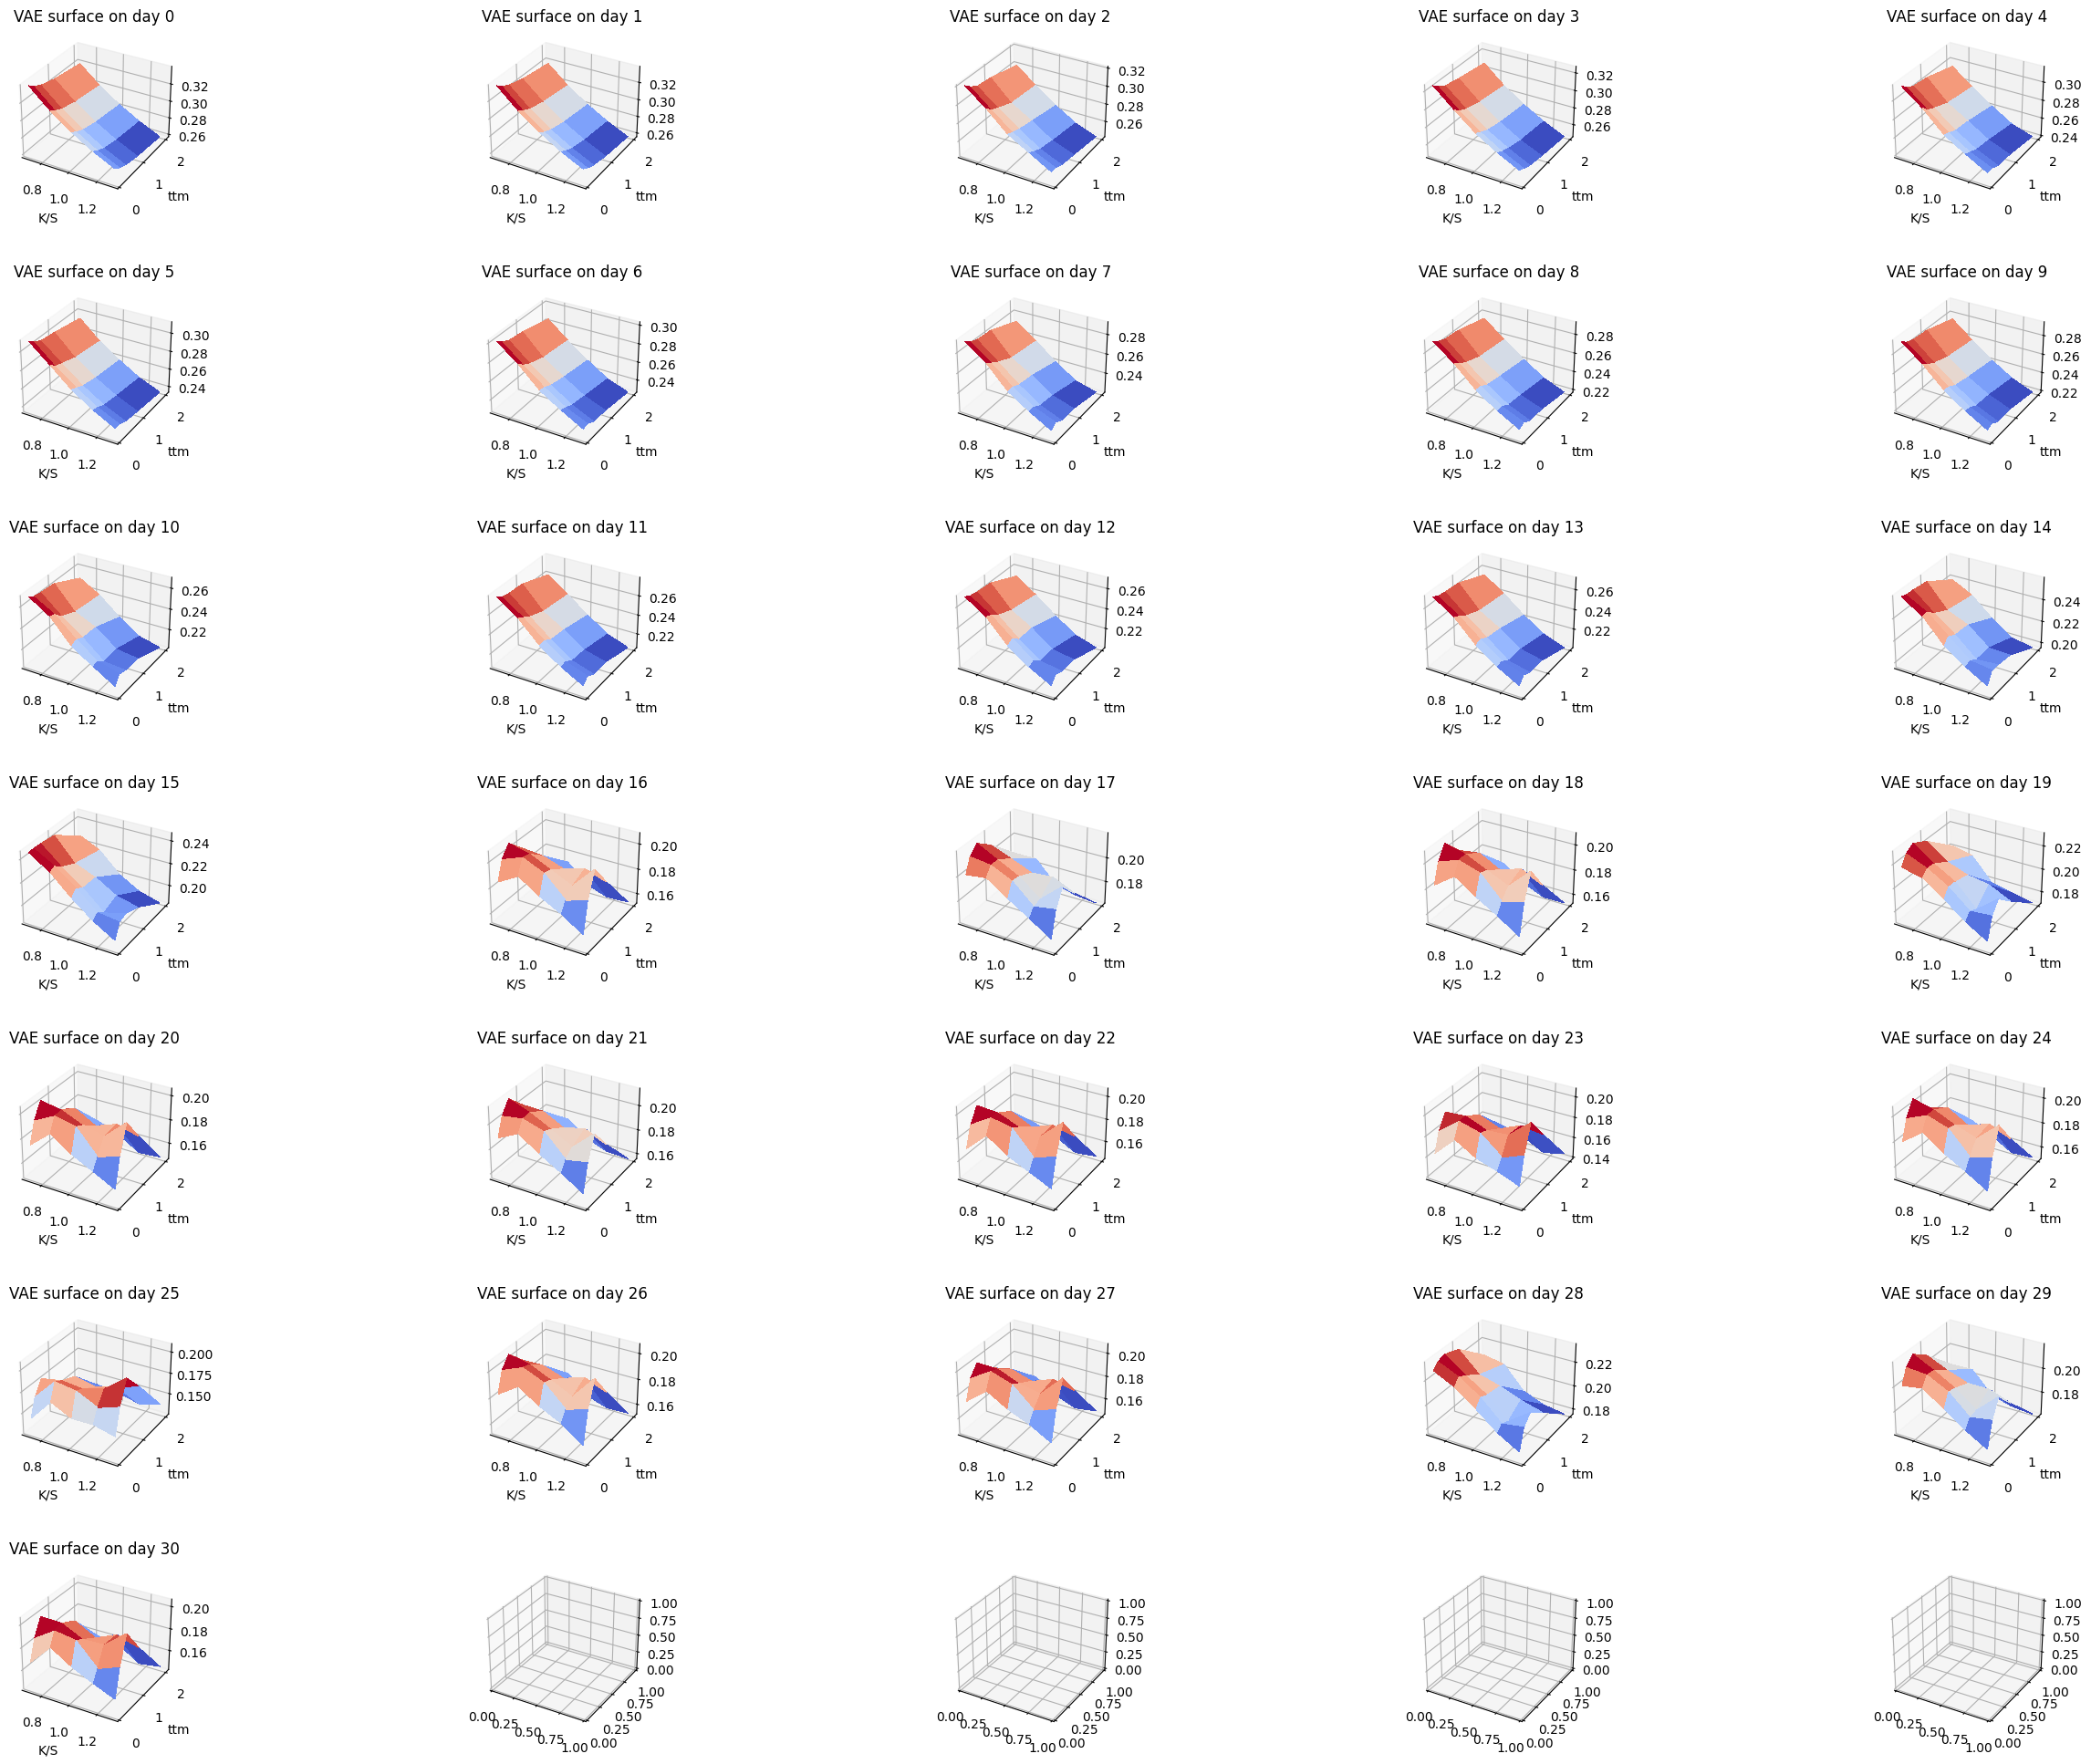

In [25]:
plot_surface_time_series(sim)